In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Variabili di base

In [ ]:
# File containing the images
#file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\febbraio\arcturus_633nm_10ms.ome.tif")
# Select the specific image to study
#imagenumber = 901

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=5000 #7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
#plate_scale = 0.0377 #gennaio
#plate_scale = 0.012 #marzo
plate_scale = 0.0109 #febbraio

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
#wavelength = 700e-9  
wavelength = 633e-9   # Reference wavelenght (in meters) 
max_ellipticity = 0.2

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
expected_speckle_size_radians = 0.8038 *(1.22 * wavelength / aperture)
expected_speckle_size = expected_speckle_size_radians * 206265  
expected_speckle_size_pixels = expected_speckle_size / plate_scale

# Radius use for the fit of the speckles (in pixels)
radius=int((diffraction_limit_arcseconds/plate_scale)/2)

print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds, diffraction_limit_arcseconds/plate_scale)
print("Expected speckle size in arcseconds and pixels: ", expected_speckle_size, expected_speckle_size/plate_scale)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds*0.5/plate_scale) # corrisponde al raggio del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)


# wavelength = 683e-9 
# diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
# diffraction_limit_arcseconds = diffraction_limit_radians * 206265
# print("Diffraction limit in arcseconds: ", diffraction_limit_arcseconds)

Diffraction limit in arcseconds and pixels:  0.17504418560439558 16.05909959673354
Expected speckle size in arcseconds and pixels:  0.07035025819440659 6.45415212792721
Check radius in pixels:  8


In [ ]:
ome_data = tifffile.imread(file)[:5000]
print (len(ome_data))

8136


## Funzioni

In [10]:

from astropy.modeling import models, fitting

def calcProcessTime(starttime, cur_iter, max_iter):

    telapsed = time.time() - starttime
    testimated = (telapsed/cur_iter)*(max_iter)
    finishtime = starttime + testimated
    finishtime = dt.datetime.fromtimestamp(finishtime).strftime("%H:%M:%S")
    lefttime = testimated-telapsed 

    return (int(telapsed), int(lefttime), finishtime)


def fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale):
    fwhm_results = []
    centers = []
    
    for speckle in filtered_speckles:
        y_ref, x_ref = speckle  
        masked_data = data.copy() 
        y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
        masked_data[masked_data < 0] = 0 
        
        ###########################################################################
        #Se attivo, fa il fit in una regione circolare
        distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
        circular_mask = distance <= radius
        masked_data = np.where(circular_mask, masked_data, 0)
        ##############################################################################
        
        # Set border pixels to 0
        masked_data[0, :] = 0
        masked_data[-1, :] = 0
        masked_data[:, 0] = 0
        masked_data[:, -1] = 0

        gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
        gaussian_model.amplitude.min = speckle_threshold
        gaussian_model.amplitude.max = masked_data.max()
        gaussian_model.x_mean.min = x_ref - 5   # METTERE A 1 PER LE SPECKLE A 3X
        gaussian_model.x_mean.max = x_ref + 5
        gaussian_model.y_mean.min = y_ref - 5
        gaussian_model.y_mean.max = y_ref + 5

        fitter = fitting.LevMarLSQFitter()
        fitted_model = fitter(gaussian_model, x, y, masked_data)

        fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
        fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
        fwhm_results.append((fwhm_y, fwhm_x))
        centers.append((fitted_model.y_mean.value, fitted_model.x_mean.value))

    return np.array(fwhm_results), np.array(centers)


def gaussiana(bins, media, sigma):
	x = np.zeros(len(bins)-1)
	for i in range(len(x)):
		x[i] = (bins[i]+bins[i+1])/2
	y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-media)**2/(2*sigma**2))
	return x, y

# Codice

In [22]:

from astropy.stats import sigma_clip
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats

ome_data = tifffile.imread(file)[:5000]

confirmation = input("Do you want to continue with the code execution? Y/N:")

if confirmation == 'y':
    pass
else:
    print("Code stopped.")
    raise SystemExit

print('Executing code...')

start = time.time()

fwhm_mean_all = []
fwhm_median_all = []
fwhm_std_all = []
centroid_all = []   # first coordinate in the array is the Y
rms_all = []        # first coordinate in the array is the Y
fwhm_mean_filtered_all = []
fwhm_median_filtered_all = []
fwhm_std_filtered_all = []
rms_filtered_all = []
centroid_filtered_all = []

for imagenumber in range(len(ome_data)):

    data_raw = ome_data[imagenumber]
    data_clean = data_raw
    poisson_error = np.sqrt(data_raw)

    background_level = np.median(data_raw)
    background_error = np.sqrt(background_level)
    noise = np.sqrt(np.mean(poisson_error**2) + background_error**2)

    background_estimate = data_raw - noise
    background_estimate[background_estimate < 0] = 0

    data = data_raw - background_level
    data[data < 0] = 0

    ###############################################################################
    ###############################################################################################
    ###########################     SOLO PER 10KHZ ################################################
    #center_y, center_x = data.shape[0] // 2, data.shape[1] // 2

    #search_radius = 80  ###per speckle a 3x

    #y, x = np.ogrid[:data.shape[0], :data.shape[1]]
    #mask = (x - center_x)**2 + (y - center_y)**2 <= search_radius**2
    #speckle_coords = np.column_stack(np.where((data > speckle_threshold) & mask))
    ################################################################################################
    ################################################################################################

    # QUANDO NON ATTIVO SPECKLE A 10KHZ
    speckle_coords = np.column_stack(np.where(data > speckle_threshold))
    
    real_speckles = []

    for coord in speckle_coords:
        y, x = coord
        max_count = data[y, x]
        speckle = coord
        
        # Check the surrounding pixels within the radius
        for dy in range(-check_radius, check_radius + 1):
            for dx in range(-check_radius, check_radius + 1):
                ny, nx = y + dy, x + dx
                if 0 <= ny < data.shape[0] and 0 <= nx < data.shape[1]:
                    if data[ny, nx] > max_count:
                        max_count = data[ny, nx]
                        speckle = [ny, nx]
                        
        if not any(np.array_equal(speckle, x) for x in real_speckles):
            real_speckles.append(speckle)
            
    real_speckles = np.array(real_speckles)


    filtered_speckles = []

    # for speckle in real_speckles:
    #     y, x = speckle
    #     max_count = data[y, x]
    #     keep_speckle = True
        
    #     # Check for adjacent speckles
    #     for dy in range(-1, 2):
    #         for dx in range(-1, 2):
    #             ny, nx = y + dy, x + dx
    #             if [ny, nx] in filtered_speckles:
    #                 if data[ny, nx] > max_count:
    #                     keep_speckle = False
    #                 else:
    #                     filtered_speckles.remove([ny, nx])
        
    #     if keep_speckle:
    #         filtered_speckles.append([y, x])
            
    for speckle in real_speckles:
        y, x = speckle
        max_count = data[y, x]
        keep_speckle = True
        # Check for speckles that are closer than N pixels
        for other_speckle in filtered_speckles:
            distance = np.sqrt((other_speckle[0] - y)**2 + (other_speckle[1] - x)**2)
            if distance < 5:   # change here to change the radius (in pixels)
                if data[other_speckle[0], other_speckle[1]] > max_count:
                    keep_speckle = False
                else:
                    filtered_speckles = [fs for fs in filtered_speckles if not np.array_equal(fs, other_speckle)]
    
        if keep_speckle:
            filtered_speckles.append([y, x])

    filtered_speckles = np.array(filtered_speckles)
###################################à SOLO PER 10KHZ ##############################################
###############################################################################################        
    # Calculate the barycenter of the filtered speckles
    #barycenter_x = filtered_speckles[:, 1].mean()
    #barycenter_y = filtered_speckles[:, 0].mean()

# Define a maximum distance from the barycenter to consider a speckle as valid
    #max_distance = 50  
    #distances = np.sqrt((filtered_speckles[:, 1] - barycenter_x)**2 + (filtered_speckles[:, 0] - barycenter_y)**2)
    #filtered_speckles = filtered_speckles[distances <= max_distance]
        
#############################################################################
################################################################################################################
  

    ############################################################################################################
    
    
    fwhm_single_image = []

    
    fwhm_single_image, centers = fit_speckle_tot(data, filtered_speckles, radius, speckle_threshold, plate_scale)

    #fwhm_results = []
    #fwhm_single_image = []
    # for speckle in filtered_speckles:
    #     y_ref, x_ref = speckle  
    #     masked_data = data.copy() 
    #     y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    #     #distance = np.sqrt((x - x_ref)**2 + (y - y_ref)**2)
    #     #circular_mask = distance <= radius
    #     masked_data = masked_data[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
    #     masked_data[masked_data < 0] = 0 
        
    #     ###########################################################################
    #     #Se attivo, fa il fit in una regione circolare
    #     #masked_data = np.where(circular_mask, masked_data, 0)
    #     ##############################################################################
    
    #     # Set border pixels to 0
    #     masked_data[0, :] = 0
    #     masked_data[-1, :] = 0
    #     masked_data[:, 0] = 0
    #     masked_data[:, -1] = 0

    #     gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=0.5, y_stddev=0.5)
    #     gaussian_model.amplitude.min = speckle_threshold
    #     gaussian_model.amplitude.max = masked_data.max()
    #     gaussian_model.x_mean.min = x_ref - 1
    #     gaussian_model.x_mean.max = x_ref + 1
    #     gaussian_model.y_mean.min = y_ref - 1
    #     gaussian_model.y_mean.max = y_ref + 1

    #     fitter = fitting.LevMarLSQFitter()
    #     fitted_model = fitter(gaussian_model, x, y, masked_data)

    #     fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
    #     fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale
    #     fwhm_results.append((fwhm_y, fwhm_x))

    # fwhm_single_image = np.array(fwhm_results)

#########################################################################################
    #########################################################################################
    #### FILTRA LE SPECKLE CON ELLITTICITà MAGGIORE DI N
    ##################################################################
    ellipticity = 1 - np.minimum(fwhm_single_image[:, 0], fwhm_single_image[:, 1]) / np.maximum(fwhm_single_image[:, 0], fwhm_single_image[:, 1])
    #fwhm_single_image = fwhm_single_image[ellipticity < max_ellipticity]
    #centers = centers[ellipticity < max_ellipticity]
    ##################################################################
    

    # Initialize lists to store filtered FWHM and centers
    fwhm_single_image_filtered = []
    centers_filtered = []

    # Filter speckles based on ellipticity
    for i in range(len(fwhm_single_image)):
        if ellipticity[i] < max_ellipticity:
            fwhm_single_image_filtered.append(fwhm_single_image[i])
            centers_filtered.append(centers[i])

    fwhm_single_image_filtered = np.array(fwhm_single_image_filtered)
    centers_filtered = np.array(centers_filtered)
    
    # Statistics for ellipticity-filtered speckles
    if len(fwhm_single_image_filtered) > 0:
        fwhm_x_clipped_filtered = sigma_clip(fwhm_single_image_filtered[:, 1], sigma=3, maxiters=1)
        fwhm_x_tot_clean_filtered = fwhm_single_image_filtered[~fwhm_x_clipped_filtered.mask]
    
        mean_clipped_fwhm_filtered = np.mean(fwhm_x_tot_clean_filtered[:, 1])
        median_clipped_fwhm_filtered = np.ma.median(fwhm_x_tot_clean_filtered[:, 1])
        std_clipped_fwhm_filtered = np.std(fwhm_x_tot_clean_filtered[:, 1])
    
        centroid_filtered = (np.mean(centers_filtered[:, 0]), np.mean(centers_filtered[:, 1]))
        rms_filtered = (np.sqrt(np.mean((centers_filtered[:, 0] - centroid_filtered[0])**2)), np.sqrt(np.mean((centers_filtered[:, 1] - centroid_filtered[1])**2)))
        
        # Store results for ellipticity-filtered speckles
        fwhm_mean_filtered_all.append(mean_clipped_fwhm_filtered)
        fwhm_median_filtered_all.append(median_clipped_fwhm_filtered)
        fwhm_std_filtered_all.append(std_clipped_fwhm_filtered)
        rms_filtered_all.append(rms_filtered)
        centroid_filtered_all.append(centroid_filtered)
    else:
        # Handle the case where no speckles pass the ellipticity filter
        mean_clipped_fwhm_filtered = np.nan
        median_clipped_fwhm_filtered = np.nan
        std_clipped_fwhm_filtered = np.nan
        centroid_filtered = (np.nan, np.nan)
        rms_filtered = (np.nan, np.nan)
        fwhm_mean_filtered_all.append(mean_clipped_fwhm_filtered)
        fwhm_median_filtered_all.append(median_clipped_fwhm_filtered)
        fwhm_std_filtered_all.append(std_clipped_fwhm_filtered)
        rms_filtered_all.append(rms_filtered)
        centroid_filtered_all.append(centroid_filtered)

  #  sigma clipping
    #tutto con indice 1 perché si sta facendo statistica solo sulla X
    fwhm_x_clipped = sigma_clip(fwhm_single_image[:, 1], sigma=3, maxiters=1)  # o 1 a 3 sigma o 3 a 3.5 sigma
    fwhm_x_tot_clean = fwhm_single_image[~fwhm_x_clipped.mask]
    mean_clipped_fwhm = np.mean(fwhm_x_tot_clean[:,1])
    median_clipped_fwhm = np.ma.median(fwhm_x_tot_clean[:,1])
    std_clipped_fwhm = np.std(fwhm_x_tot_clean[:,1]) 
    centroid = (np.mean(centers[:,0]), np.mean(centers[:,1])) 
    rms = (np.sqrt(np.mean((centers[:,0] - centroid[0])**2)), np.sqrt(np.mean((centers[:,1] - centroid[1])**2))) 
    # mean_clipped_fwhm = np.mean(fwhm_x_tot_clean)
    # median_clipped_fwhm = np.ma.median(fwhm_x_tot_clean)
    # std_clipped_fwhm = np.std(fwhm_x_tot_clean)

    # Store results for all speckles
    fwhm_mean_all.append(mean_clipped_fwhm)
    fwhm_median_all.append(median_clipped_fwhm)
    fwhm_std_all.append(std_clipped_fwhm)
    rms_all.append(rms)
    centroid_all.append(centroid)
    

    

    
    
 
    
    
#     centroid = (np.mean(centers[:,0]), np.mean(centers[:,1])) 
#     rms = (np.sqrt(np.mean((centers[:,0] - centroid[0])**2)), np.sqrt(np.mean((centers[:,1] - centroid[1])**2)))
    
#     # salva nei vettori da mettere nell'istogramma alla fine
#     fwhm_mean_all.append(mean_clipped_fwhm)
#     fwhm_median_all.append(median_clipped_fwhm)
#     fwhm_std_all.append(std_clipped_fwhm)
#     rms_all.append(rms)
#     centroid_all.append(centroid)
    

    if imagenumber % 500 == 0:
        prstime = calcProcessTime(start, imagenumber +1 ,len(ome_data))
        print("time elapsed: %s s, time left: %s s, estimated finish time: %s"%prstime)
    
print('Speckles fit done')


Executing code...
time elapsed: 4 s, time left: 21775 s, estimated finish time: 19:20:00


time elapsed: 1740 s, time left: 15626 s, estimated finish time: 18:06:27


ValueError: operands could not be broadcast together with shapes (17,17) (17,0) () 

In [23]:

print(ellipticity)
print(len(fwhm_single_image_filtered))
print(len(fwhm_single_image))
print(np.sum(ellipticity < max_ellipticity))


[0.22910091 0.2514649  0.09611287 0.29873775 0.33042602 0.19921071
 0.09461538 0.24043648 0.15712096 0.1742824  0.30831643 0.12861205
 0.26314872 0.07075615 0.36752152 0.15153769 0.1835787  0.24619398
 0.1249533  0.36653615 0.11430317 0.26478276 0.09839435 0.23446869
 0.38746054 0.21079468 0.37529674 0.23612602 0.23549055 0.09438492
 0.32815008 0.01090449 0.26651826 0.30841587 0.16337627 0.03573388
 0.27658422 0.1575996  0.24137346 0.15651569 0.35004041 0.1827207
 0.36249301 0.09962722 0.29870118 0.24786967 0.5062748  0.11332892
 0.22734128 0.02636231 0.23901922 0.10405936 0.08088462 0.31612577
 0.31257691 0.07181221 0.12537264 0.36846964 0.45703261 0.11088249
 0.29620914 0.26053109 0.29899813 0.14788641 0.54211706 0.37103885
 0.24756398 0.21490667 0.02401476 0.13599171 0.11725634 0.2872101
 0.23832006 0.37585479 0.08959346 0.21138008 0.20975215 0.49578954
 0.03190035]
33
0
33


## Salvataggio dei risultati in file

In [ ]:
from astropy.io import fits

primary_hdu = fits.PrimaryHDU()
fwhm_mean_hdu = fits.ImageHDU(data=np.array(fwhm_mean_all), name='FWHM_MEAN')
fwhm_median_hdu = fits.ImageHDU(data=np.array(fwhm_median_all), name='FWHM_MEDIAN')
fwhm_std_hdu = fits.ImageHDU(data=np.array(fwhm_std_all), name='FWHM_STD')
centroid_hdu = fits.ImageHDU(data=np.array(centroid_all), name='CENTROID')
rms_hdu = fits.ImageHDU(data=np.array(rms_all), name='RMS')

hdul = fits.HDUList([primary_hdu, fwhm_mean_hdu, fwhm_median_hdu, fwhm_std_hdu, centroid_hdu, rms_hdu])

hdul.writeto('outputs\resultsPARTIAL_arcturus_633nm_10ms_6X_threshold5000.fits"', overwrite=True)

hdul.close()

<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
C:\Users\buonc\AppData\Local\Temp\ipykernel_24344\1979807318.py:12: SyntaxWarning: invalid escape sequence '\o'
  hdul.writeto('\outputs\resultsPARTIAL_arcturus_633nm_10ms_6X_threshold5000.fits"', overwrite=True)
C:\Users\buonc\AppData\Local\Temp\ipykernel_24344\1979807318.py:12: SyntaxWarning: invalid escape sequence '\o'
  hdul.writeto('\outputs\resultsPARTIAL_arcturus_633nm_10ms_6X_threshold5000.fits"', overwrite=True)


OSError: [Errno 22] Invalid argument: '\\outputs\resultsPARTIAL_arcturus_633nm_10ms_6X_threshold5000.fits"'

## Fotometria

(512, 512)
512
Number of sources found: 1


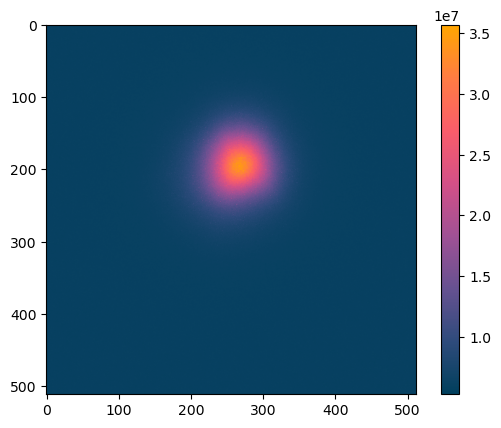

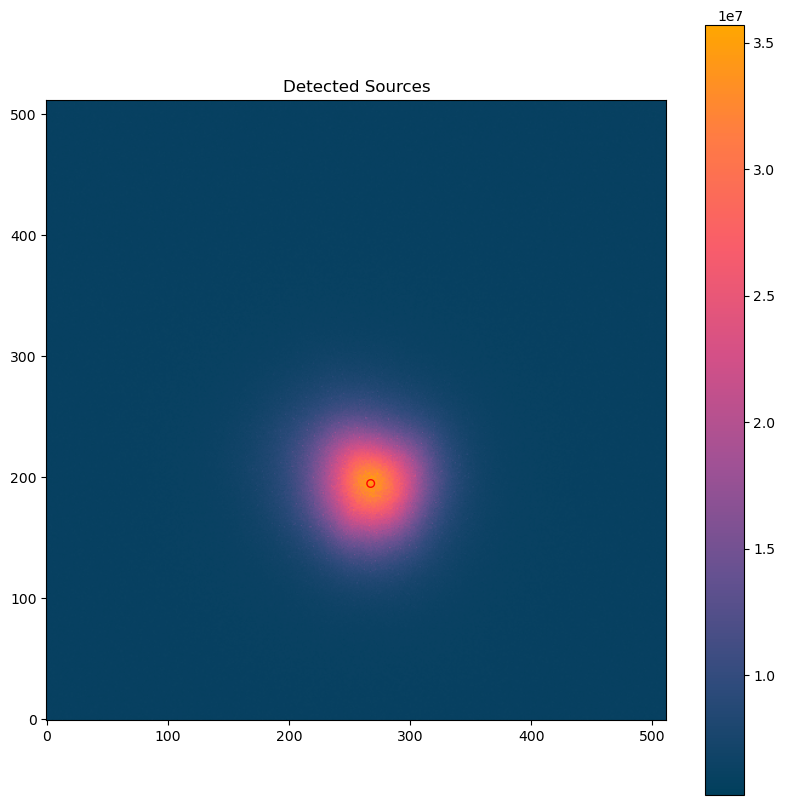

Source ID: 1, X: 267.3588037870143, Y: 194.80115898347916
max value no cleaning = 35704094
Background mean counts per pixel: 6068789.423795538
max counts in the image: 29635304.576204464
Final flux= 199633750389.30975 +- 20342046.035947595
68 199633750389.30975
R 80 = 69 pixels, 2.5944000000000003 arcsec
42 199633750389.30975
R 50 = 43 pixels, 1.6168 arcsec
FWHM  = 3.2336 arcsec
Flux at R50 = 101187841638.62964 +- 7350487.2230735


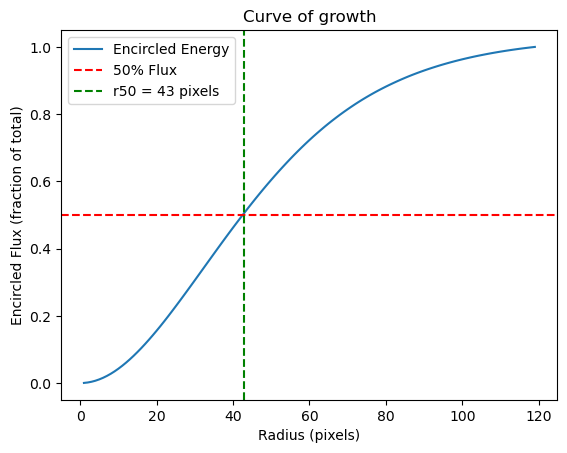

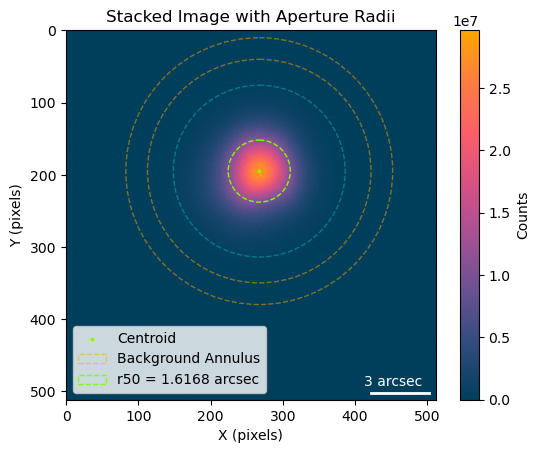

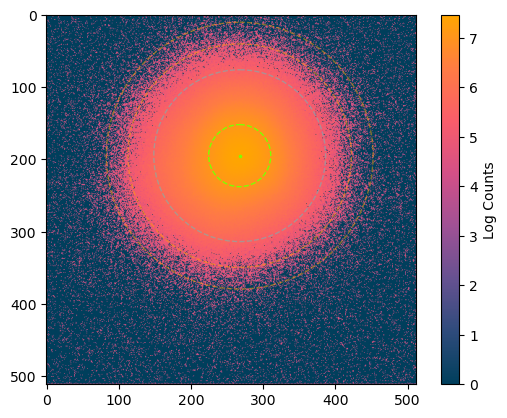

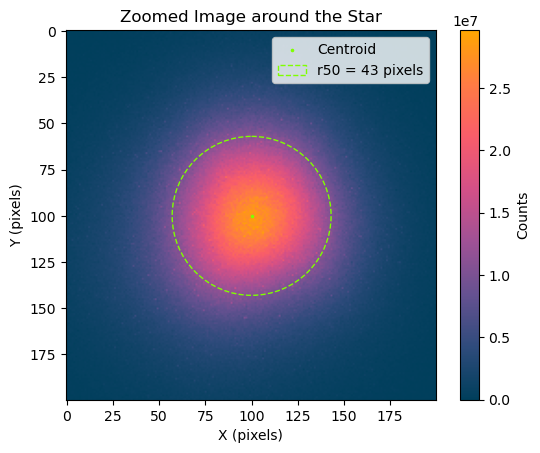

r0 aperture photometry = 0.000010 [m]
r0 aperture photometry = 0.043759 [m]
Error in Fitted FWHM: ±0.02 arcseconds (x), ±0.02 arcseconds (y)
Fitted FWHM: 2.78 x 2.88 arcseconds, 74.06 x 76.54 pixel
Fitted Centroid: (np.float64(266.66583410095046), np.float64(194.59681265151994))
Fitted Max Amplitude: 29651258.0
Original Centroid: (267, 194)
Original Max Amplitude: 29651758.0


C:\Users\buonc\AppData\Local\Temp\ipykernel_18080\3304705256.py:312: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='large')


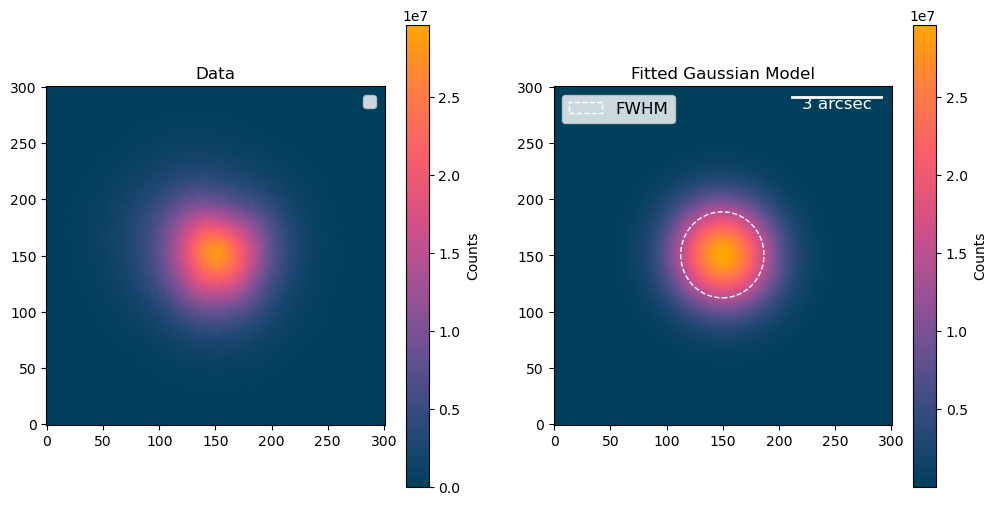

Max value of the residuals: 4217079.361352844
Min value of the residuals: -5480053.512149565
Mean value of the residuals: 170146.52527184875


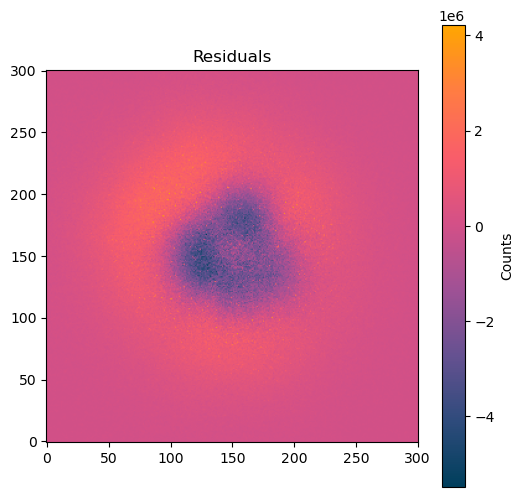

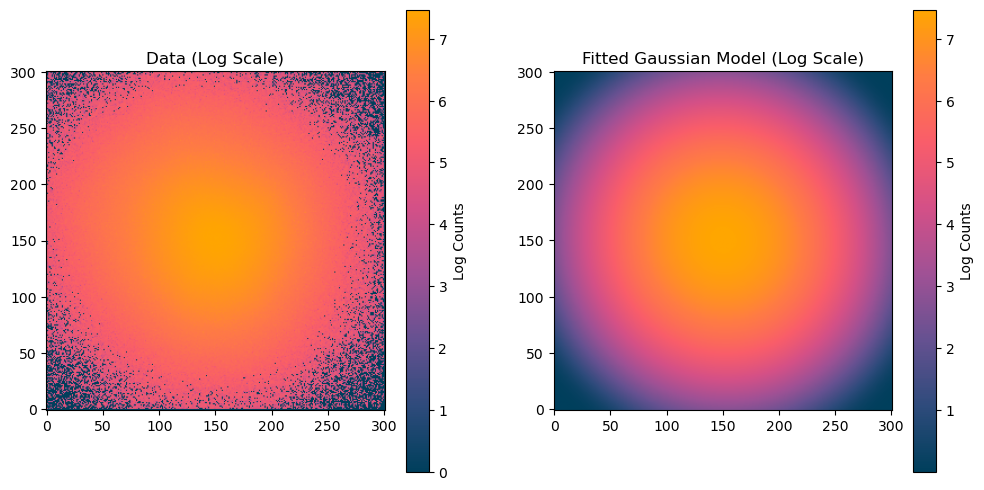

C:\Users\buonc\AppData\Local\Temp\ipykernel_18080\3304705256.py:364: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')


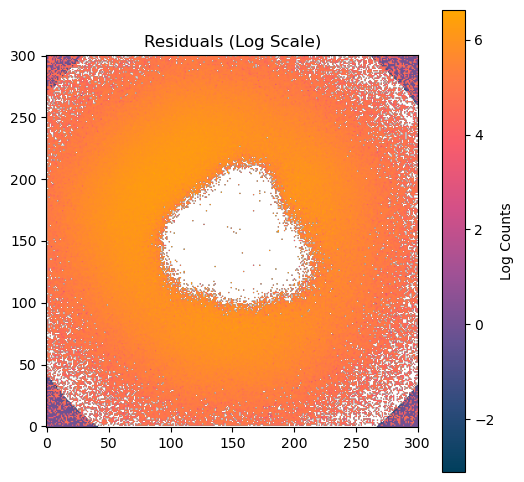

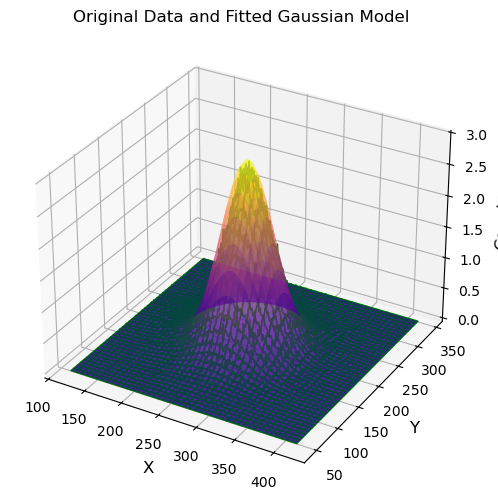

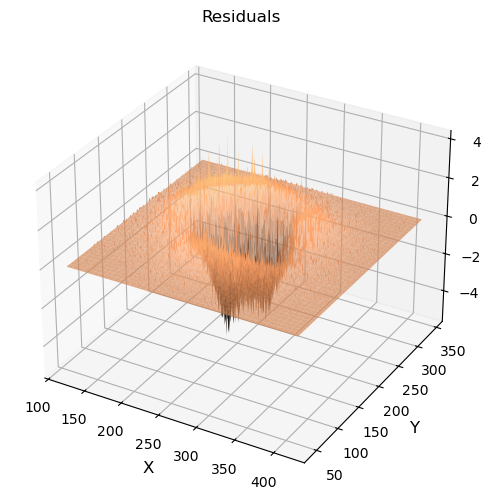

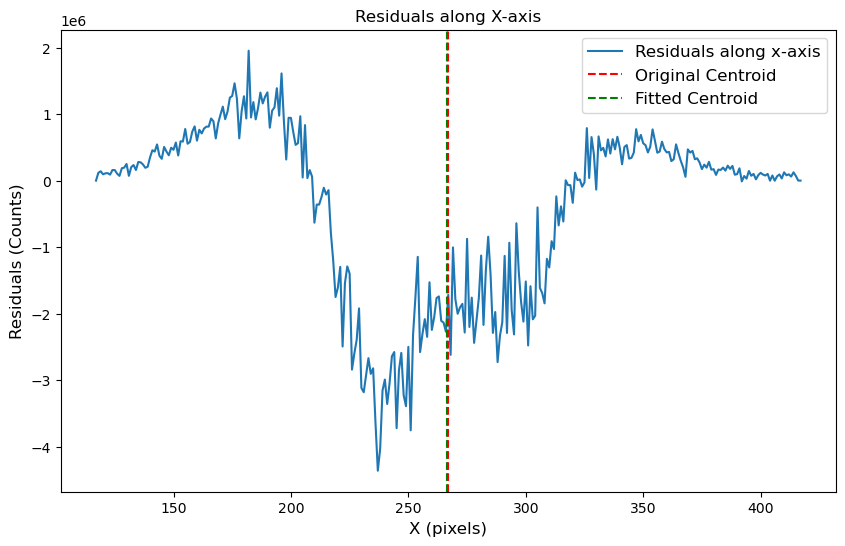

r0 Gauss fit = 0.050592 [m]


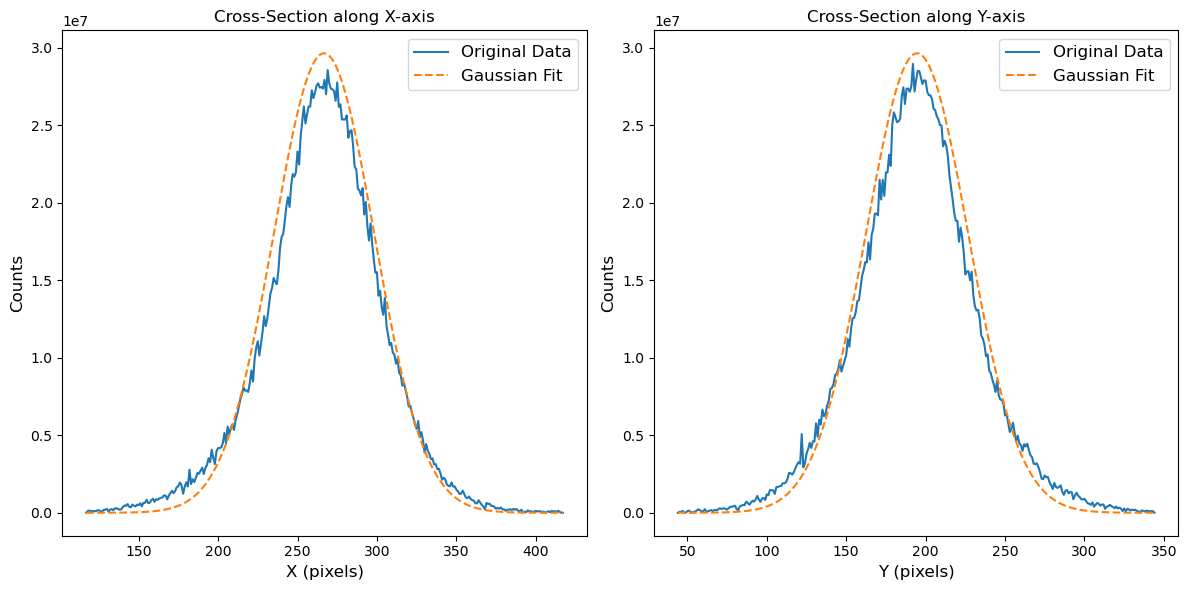

In [70]:
import tifffile
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats

ome_data = tifffile.imread(file)
data_photometry = np.sum(ome_data, axis=0)   # SI PUò CAMBIARE IN np.sum

#data_photometry = tifffile.imread(file)
#Read the FITS file
# with fits.open(file) as hdul:
#     data_photometry = hdul[0].data


ref_image = data_photometry.copy()
print(ref_image.shape)
print(len(data_photometry))
plt.imshow(ref_image, cmap=custom_cmap)
plt.colorbar()


###################### smoothing dell'immagine
#################################################

# # Apply Gaussian smoothing to the image
# sigma = 2  # più è alto il valore più è "sfocata" l'immagine finale
# smoothed_image = gaussian_filter(ref_image, sigma=sigma)
# ref_image = np.copy(smoothed_image)

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(ref_image, cmap=custom_cmap)
# plt.colorbar()
# plt.title("Original Image")

# plt.subplot(1, 2, 2)
# plt.imshow(smoothed_image, cmap=custom_cmap)
# plt.colorbar()
# plt.title("Smoothed Image")

# plt.show()





mean, median, std = sigma_clipped_stats(ref_image, sigma=3.0)
# Initialize the DAOStarFinder 
daofind = DAOStarFinder(fwhm=50.0, threshold=20.*std)

sources = daofind(ref_image - median)

print(f"Number of sources found: {len(sources)}")

plt.figure(figsize=(10, 10))
plt.imshow(ref_image, cmap=custom_cmap, origin='lower')
plt.colorbar()
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none')
plt.title('Detected Sources')
plt.show()

for source in sources:
    print(f"Source ID: {source['id']}, X: {source['xcentroid']}, Y: {source['ycentroid']}")
    
#print(sources[1]['xcentroid'])



# SCEGLIE IL CENTROIDE DI RIFERIMENTO ###############################################################
#####################################################################################################
centroid_x, centroid_y = sources[0]['xcentroid'], sources[0]['ycentroid']
center = (centroid_x, centroid_y)
###########################################################################################################
###########################################################################################################


max_radius = min(center[1], center[0], ref_image.shape[0] - center[0], ref_image.shape[1] - center[1])
max_radius_ds9 = 120 # raggio della PSF visto in DS9 (controllare da lì prima di partire col codice)

inner_radius = max_radius - 40
outer_radius = max_radius - 10
annulus_aperture = CircularAnnulus(center, r_in=inner_radius, r_out=outer_radius)

# Perform aperture photometry on the annulus to get the background
annulus_stats = ApertureStats(ref_image, annulus_aperture)
background_mean = annulus_stats.mean
image_stack = ref_image.copy() - background_mean
image_stack[image_stack < 0] = 0

print(f'max value no cleaning = {np.max(ref_image)}')
print(f"Background mean counts per pixel: {background_mean}")
print(f'max counts in the image: {np.max(image_stack)}')


radii = np.arange(1, max_radius_ds9, 1)

fluxes = []
flux_errors = []

# Create an error array with the same shape as image_stack
error_array = np.full(image_stack.shape, std)

for r in radii:
    aperture = CircularAperture(center, r)
    phot_table = aperture_photometry(image_stack, aperture, error=error_array)
    flux = phot_table['aperture_sum'][0]
    flux_error = phot_table['aperture_sum_err'][0]
    if len(fluxes) > 0 and (flux - fluxes[-1]) / fluxes[-1] < 0.0001:
        break
    fluxes.append(flux)
    flux_errors.append(flux_error)
print(f"Final flux= {flux} +- {flux_error}")

fluxes = np.array(fluxes)
total_flux = fluxes[-1]

#print(fluxes/total_flux, radii)  


r80_index = np.where(fluxes >= 0.8 * total_flux)[0][0]  ### qui si sceglie r
r80 = radii[r80_index]
print(r80_index, total_flux )
print(f"R 80 = {r80} pixels, {r80 * plate_scale} arcsec")

r80_index = np.where(fluxes >= 0.50 * total_flux)[0][0]  ### qui si sceglie r
r80 = radii[r80_index]
print(r80_index, total_flux )
print(f"R 50 = {r80} pixels, {r80 * plate_scale} arcsec")
print(f"FWHM  = {r80*2*plate_scale} arcsec")
print(f"Flux at R50 = {fluxes[r80_index]} +- {flux_errors[r80_index]}")



plt.figure()
plt.plot(radii[:len(fluxes)], fluxes / total_flux , label='Encircled Energy')
plt.axhline(0.5, color='r', linestyle='--', label='50% Flux')
plt.axvline(r80, color='g', linestyle='--', label=f'r50 = {r80} pixels')
plt.xlabel('Radius (pixels)')
plt.ylabel('Encircled Flux (fraction of total)')
plt.legend()
plt.title('Curve of growth')
plt.show()

plt.figure()
plt.imshow(image_stack, cmap=custom_cmap)
plt.colorbar(label='Counts')
plt.scatter(center[0], center[1] , color='chartreuse', marker='.', s=10, label='Centroid')


aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5)#, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r50 = {r80*plate_scale} arcsec')
plt.gca().add_patch(circle_r80)


scalebar_length_pixels = 79.5#26.52#50  
scalebar = plt.Line2D([image_stack.shape[1] - scalebar_length_pixels - 10, image_stack.shape[1] - 10],
                      [image_stack.shape[0] - 10, image_stack.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(image_stack.shape[1] - scalebar_length_pixels / 2 - 20, image_stack.shape[0] - 20, '3 arcsec', color='white', ha='center')


plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.title('Stacked Image with Aperture Radii')
plt.show()

# Show the image with logarithmic counts
plt.figure()
plt.imshow(np.log10(image_stack +1), cmap=custom_cmap)
plt.colorbar(label='Log Counts')
plt.scatter(center[0] , center[1], color='chartreuse', marker='.', s=10, label='Centroid')


aperture = plt.Circle(center, radii[len(fluxes)-1], color='cyan', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_patch(aperture)

annulus_aperture_patch = plt.Circle(center, outer_radius, color='orange', fill=False, linestyle='--', alpha=0.5) #, label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)
annulus_aperture_patch = plt.Circle(center, inner_radius, color='orange', fill=False, linestyle='--', alpha=0.5) #label='Background Annulus')
plt.gca().add_patch(annulus_aperture_patch)

circle_r80 = plt.Circle(center, r80, color='chartreuse', fill=False, linestyle='--', label=f'r50 = {r80} pixels')
plt.gca().add_patch(circle_r80)


zoom_size = 100  
x_min = int(center[0] - zoom_size )
x_max = int(center[0] + zoom_size )
y_min = int(center[1] - zoom_size )
y_max = int(center[1] + zoom_size )

zoomed_image = image_stack[y_min:y_max, x_min:x_max]

plt.figure()
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.colorbar(label='Counts')
plt.scatter(zoom_size , zoom_size , color='chartreuse', marker='.', s=10, label='Centroid')

aperture = plt.Circle((zoom_size , zoom_size ), r80, color='chartreuse', fill=False, linestyle='--', label=f'r50 = {r80} pixels')
plt.gca().add_patch(aperture)

plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.title('Zoomed Image around the Star')
plt.show()




#######################################################################
#fwhm_radians = r80*2*plate_scale * (np.pi / 180) / 3600
#r0 = 0.98* wavelength / fwhm_radians

#fwhm_radians = ((r80*2) * plate_scale) / 260265
#r0 = 0.98 * wavelength / (fwhm_radians * 35.501)
#fwhm_radians = r80*2 / 260265
r0 = 0.98 * wavelength *35.501 / (r80*2 * 6.5e-6)
r0 = 0.98 * wavelength * 35.501 /(r80 * 2 ) *35.501

print(f"r0 aperture photometry = {r0:.6f} [m]")
fwhm_radians = (r80 * 2 * plate_scale) * (np.pi /(180*3600))
r0 = 0.98 * wavelength / (fwhm_radians)
print(f"r0 aperture photometry = {r0:.6f} [m]")

################ Fit Gauss ############################################
#######################################################################
from astropy.modeling import models, fitting
import numpy as np
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from photutils.psf import MoffatPSF

import matplotlib.pyplot as plt

ref_image = data_photometry.copy()#[n_image]
# rebin_factor = 2
# def rebin_image(image, rebin_factor):
#     shape = (image.shape[0] // rebin_factor, rebin_factor,
#              image.shape[1] // rebin_factor, rebin_factor)
#     return image.reshape(shape).mean(-1).mean(1)

# rebinned_data = rebin_image(data_photometry[n_image], rebin_factor)
# ref_image = rebinned_data.copy()

back = np.median(ref_image)
image_clean = ref_image.copy() - back
image_clean[image_clean<0] = 0
radius = 150 # 180 per 1khz

y_ref, x_ref = int(centroid_y), int(centroid_x)   # usa lo stesso centoride del fit con fotometria
y, x = np.mgrid[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]

masked_data = image_clean[y_ref-radius:y_ref+radius+1, x_ref-radius:x_ref+radius+1]
# Set border pixels to 0
masked_data[0, :] = 0
masked_data[-1, :] = 0
masked_data[:, 0] = 0
masked_data[:, -1] = 0

gaussian_model = models.Gaussian2D(amplitude=masked_data.max(), x_mean=x_ref, y_mean=y_ref, x_stddev=30, y_stddev=30)  # prima erano 10 e 10
gaussian_model.amplitude.min = masked_data.max() - 500
gaussian_model.amplitude.max = masked_data.max()
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(gaussian_model, x, y, masked_data)

# Calculate the errors in the FWHM estimates
x_fwhm_error = np.sqrt(np.diag(fitter.fit_info['param_cov']))[2] * plate_scale
y_fwhm_error = np.sqrt(np.diag(fitter.fit_info['param_cov']))[3] * plate_scale

print(f"Error in Fitted FWHM: ±{x_fwhm_error:.2f} arcseconds (x), ±{y_fwhm_error:.2f} arcseconds (y)")

fwhm_x = fitted_model.x_fwhm *plate_scale
fwhm_y = fitted_model.y_fwhm  *plate_scale

#fwhm_x = 2.355 * fitted_model.x_stddev.value * plate_scale
#fwhm_y = 2.355 * fitted_model.y_stddev.value * plate_scale

print(f"Fitted FWHM: {fwhm_x:.2f} x {fwhm_y:.2f} arcseconds, {fwhm_x/plate_scale:.2f} x {fwhm_y/plate_scale:.2f} pixel")
fitted_centroid = (fitted_model.x_mean.value, fitted_model.y_mean.value)
fitted_amplitude = fitted_model.amplitude.value
original_centroid = (x_ref, y_ref)
original_amplitude = masked_data.max()

print(f"Fitted Centroid: {fitted_centroid}")
print(f"Fitted Max Amplitude: {fitted_amplitude}")
print(f"Original Centroid: {original_centroid}")
print(f"Original Max Amplitude: {original_amplitude}")

####################################################
#######################   PLOTS
####################################################
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(masked_data, cmap=custom_cmap, origin='lower')
plt.title('Data', fontsize='large')
plt.colorbar(label='Counts')
plt.legend(fontsize='large')

plt.subplot(1, 2, 2)
plt.imshow(fitted_model(x, y), cmap=custom_cmap, origin='lower')
plt.title('Fitted Gaussian Model', fontsize='large')
plt.colorbar(label='Counts')

fwhm_pixel_x = fwhm_x / plate_scale
fwhm_pixel_y = fwhm_y / plate_scale

ellipse = Ellipse((fitted_model.x_mean.value - x.min(), fitted_model.y_mean.value - y.min()), 
                     fwhm_pixel_x, fwhm_pixel_y, color='white', fill=False, linestyle='--', label='FWHM')
plt.gca().add_patch(ellipse)

plt.legend(fontsize='large')

scalebar_length_pixels = 79.5 
scalebar = plt.Line2D([masked_data.shape[1] - scalebar_length_pixels - 10, masked_data.shape[1] - 10],
                      [masked_data.shape[0] - 10, masked_data.shape[0] - 10],
                      color='white', linewidth=2)
plt.gca().add_line(scalebar)
plt.text(masked_data.shape[1] - scalebar_length_pixels / 2 - 10, masked_data.shape[0] - 20, f'3 arcsec', color='white', ha='center', fontsize='large')
plt.show()

# residuals
residuals = masked_data - fitted_model(x, y)
print(f"Max value of the residuals: {residuals.max()}")
print(f"Min value of the residuals: {residuals.min()}")
print(f"Mean value of the residuals: {residuals.mean()}")

plt.figure(figsize=(6, 6))
plt.imshow(residuals, cmap=custom_cmap, origin='lower')
plt.title('Residuals', fontsize='large')
plt.colorbar(label='Counts')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.log10(masked_data + 1), cmap=custom_cmap, origin='lower')
plt.title('Data (Log Scale)', fontsize='large')
plt.colorbar(label='Log Counts')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(fitted_model(x, y) + 1), cmap=custom_cmap, origin='lower')
plt.title('Fitted Gaussian Model (Log Scale)', fontsize='large')
plt.colorbar(label='Log Counts')

plt.show()

# residuals in logarithmic scale
plt.figure(figsize=(6, 6))
plt.imshow(np.log10(residuals + 1), cmap=custom_cmap, origin='lower')
plt.title('Residuals (Log Scale)', fontsize='large')
plt.colorbar(label='Log Counts')
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

########################################
############### 3D PLOTS  ##############
########################################

ax.plot_surface(x, y, masked_data, cmap='viridis', edgecolor='green', alpha=0.7)
ax.set_title('Original Data and Fitted Gaussian Model', fontsize='large')
ax.set_xlabel('X', fontsize='large')
ax.set_ylabel('Y', fontsize='large')
ax.set_zlabel('Counts', fontsize='large')

ax.plot_surface(x, y, fitted_model(x, y), cmap='plasma', edgecolor='none', alpha=0.5)
plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, residuals, cmap='copper', edgecolor='none', alpha=0.7)
ax.set_title('Residuals', fontsize='large')
ax.set_xlabel('X', fontsize='large')
ax.set_ylabel('Y', fontsize='large')
ax.set_zlabel('Residual Counts', fontsize='large')
plt.show()

# Plot the residuals along the x-axis
plt.figure(figsize=(10, 6))
plt.plot(x[0], residuals[residuals.shape[0] // 2], label='Residuals along x-axis')
plt.axvline(x=original_centroid[0], color='r', linestyle='--', label='Original Centroid')
plt.axvline(x=fitted_centroid[0] , color='g', linestyle='--', label='Fitted Centroid')
plt.xlabel('X (pixels)', fontsize='large')
plt.ylabel('Residuals (Counts)', fontsize='large')
plt.title('Residuals along X-axis', fontsize='large')
plt.legend(fontsize='large')
plt.show()

######################## r0 ###################################
#fwhm_radians = fwhm_pixel_x*plate_scale * (np.pi / 180) / 3600
fwhm_radians = fwhm_x / 260265
r0 = 0.98 * wavelength *35.501 / (fitted_model.x_fwhm * 6.5e-6)

print(f"r0 Gauss fit = {r0:.6f} [m]")

######################### cross sections #####################

# Extract the cross-sections of the Gaussian fit along the x and y axes
x_cross_section = fitted_model(x[radius, :], y[radius, :])
y_cross_section = fitted_model(x[:, radius], y[:, radius])

# Extract the original data cross-sections along the x and y axes
original_cross_section_x = masked_data[radius, :]
original_cross_section_y = masked_data[:, radius]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x[radius, :], original_cross_section_x, label='Original Data')
plt.plot(x[radius, :], x_cross_section, label='Gaussian Fit', linestyle='--')
plt.xlabel('X (pixels)', fontsize='large')
plt.ylabel('Counts', fontsize='large')
plt.title('Cross-Section along X-axis', fontsize='large')
plt.legend(fontsize='large')

plt.subplot(1, 2, 2)
plt.plot(y[:, radius], original_cross_section_y, label='Original Data')
plt.plot(y[:, radius], y_cross_section, label='Gaussian Fit', linestyle='--')
plt.xlabel('Y (pixels)', fontsize='large')
plt.ylabel('Counts', fontsize='large')
plt.title('Cross-Section along Y-axis', fontsize='large')
plt.legend(fontsize='large')

plt.tight_layout()
plt.show()





In [65]:
immagine = image_stack #data_photometry  #sceglie l'immagine

hdu = fits.PrimaryHDU(immagine)

hdu.writeto(r'c:\Users\buonc\Desktop\1khz_stackedimage.fits', overwrite=True)

# Plot 

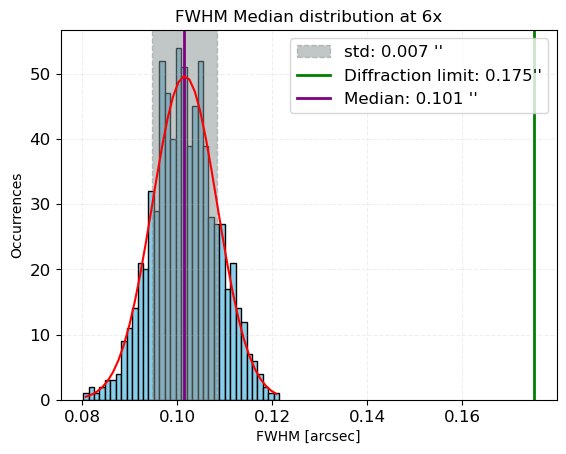

In [11]:
# Open the results file and extract the fwhm_median_all array
with fits.open(r'outputs/resultsPARTIAL_arcturus_633nm_10ms_6X_threshold5000.fits') as hdul:
    arr = hdul['FWHM_MEDIAN'].data
#arr = fwhm_median_all
extraticks=[diffraction_limit_arcseconds,np.mean(arr)]

num_bins= int(len(arr) / 20)#100)
bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color='skyblue', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('FWHM [arcsec]', fontsize='medium')
plt.ylabel('Occurrences', fontsize='medium')
plt.title('FWHM Median distribution at 6x', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
#plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f"mean value: {np.mean(arr):.3f} '' ", linewidth=0.5)
plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.5, color='#858e8e', label=f"std: {np.std(arr):.3f} ''", ls='--')
plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=2, label=f"Diffraction limit: {diffraction_limit_arcseconds:.3f}''")
plt.axvline(np.median(arr), color='purple', linestyle='-', linewidth=2, label=f"Median: {np.median(arr):.3f} ''")
#plt.text(np.mean(arr), max(bin_counts) * 0.9, f"{np.mean(arr):.2f}", color='#e52704', ha='center')
#plt.text(diffraction_limit_arcseconds, max(bin_counts) * 0.8, f"{diffraction_limit_arcseconds:.2f}", color='green', ha='center')
x, y = gaussiana(bins, np.mean(arr), np.std(arr))
#plt.xticks(list(plt.xticks()[0]) + [round(tick, 3) for tick in extraticks])
#plt.xlim(0.15, 0.25)
plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
#plt.legend(loc='upper left', fontsize='small')
plt.legend(loc='best', fontsize='large')

## istogramma centroidi rms

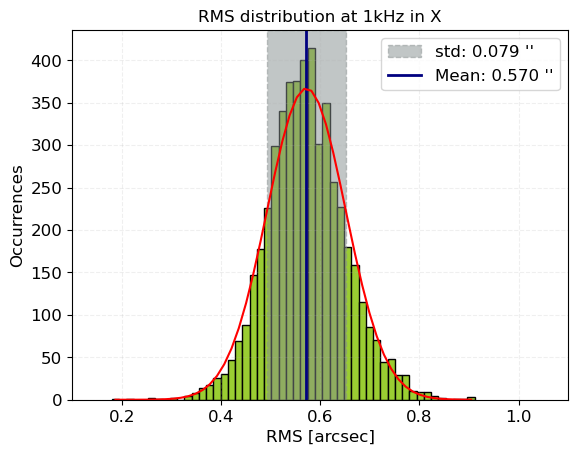

In [ ]:
# Open the results file and extract the fwhm_median_all array
with fits.open('results_500Hz_3sigma_threshold9500.fits') as hdul:
    arr = hdul['RMS'].data[:, 1] *plate_scale


#arr = fwhm_median_all
extraticks=[diffraction_limit_arcseconds,np.mean(arr)]

num_bins= int(len(arr) / 100)
bin_counts, bins, _ = plt.hist(arr, bins=num_bins, histtype='bar', align='mid', color='yellowgreen', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.2)
plt.xlabel('RMS [arcsec]', fontsize='large')
plt.ylabel('Occurrences', fontsize='large')
plt.title('RMS distribution at 1kHz in X', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
#plt.axvline(np.mean(arr), ls='-', color='#e52704', label=f"mean value: {np.mean(arr):.3f} '' ", linewidth=0.5)
plt.axvspan(xmin=np.mean(arr)-np.std(arr), xmax=np.mean(arr)+np.std(arr), alpha=0.5, color='#858e8e', label=f"std: {np.std(arr):.3f} ''", ls='--')
#plt.axvline(diffraction_limit_arcseconds, color='green', linestyle='-', linewidth=2, label=f"Diffraction limit: {diffraction_limit_arcseconds:.3f}''")
plt.axvline(np.mean(arr), color='navy', linestyle='-', linewidth=2, label=f"Mean: {np.median(arr):.3f} ''")
x, y = gaussiana(bins, np.mean(arr), np.std(arr))
plt.xlim(0.1, 1.1)
plt.plot(x, y * len(arr) * (bins[1] - bins[0]), color='red', linestyle='-') 
#plt.legend(loc='upper left', fontsize='small')
plt.legend(loc='best', fontsize='large')

## stack immagine e RMS totale e Centroide totale

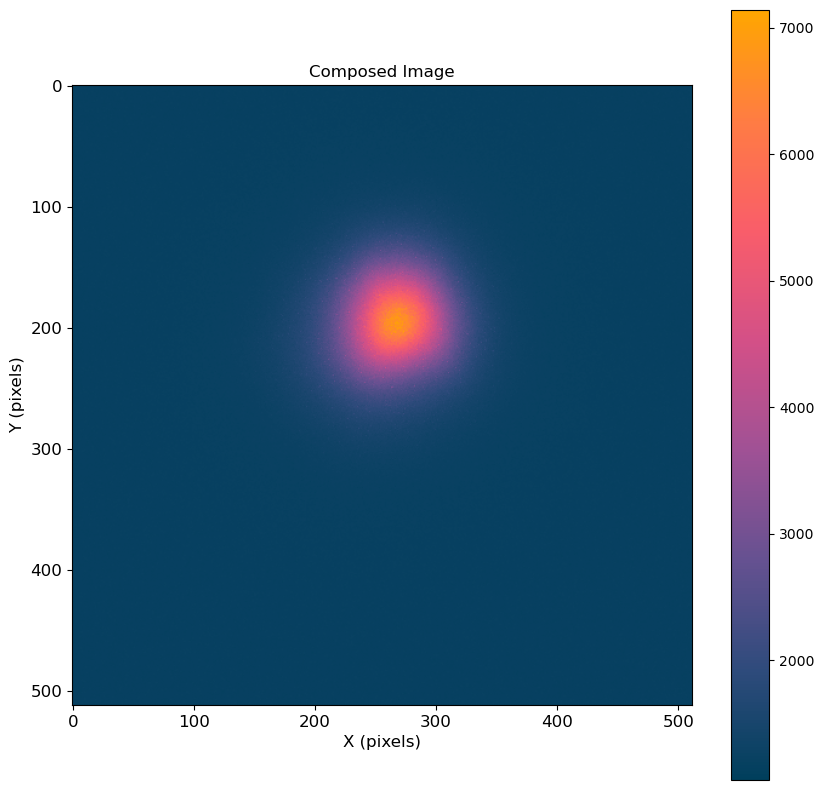

5000


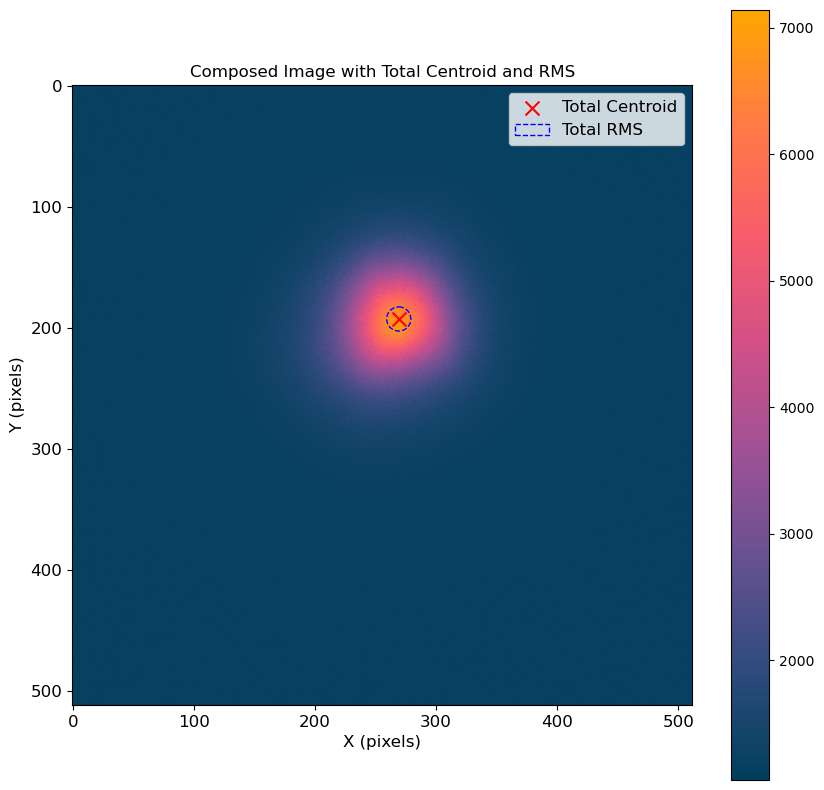

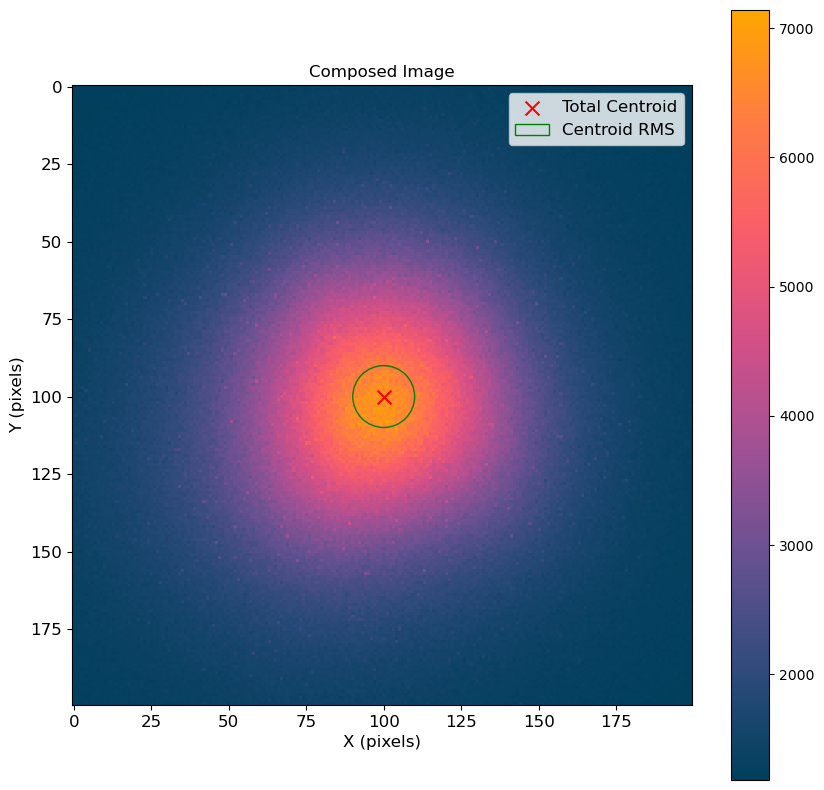

In [28]:
from scipy.ndimage import gaussian_filter

ome_data = tifffile.imread(file)
data_photometry = np.mean(ome_data, axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(data_photometry, cmap=custom_cmap)
plt.colorbar()
plt.title("Composed Image", fontsize='large')
plt.xlabel('X (pixels)', fontsize='large')
plt.ylabel('Y (pixels)', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()
ref_image = data_photometry.copy()

# Apply Gaussian smoothing to the image
sigma = 10  # Standard deviation for Gaussian kernel
#smoothed_image = gaussian_filter(ref_image, sigma=sigma)


with fits.open('results_1kHz_3sigma_threshold7000.fits') as hdul:
    centroid_all = hdul['CENTROID'].data
    rms_all = hdul['RMS'].data
print (len(centroid_all))
# Calculate the total centroid
total_centroid_y = np.mean(centroid_all[:, 0])
total_centroid_x = np.mean(centroid_all[:, 1])
# Calculate the total RMS 
total_rms_y = np.sqrt(np.mean((centroid_all[:, 0] - total_centroid_y)**2))
total_rms_x = np.sqrt(np.mean((centroid_all[:, 1] - total_centroid_x)**2))

# Plot the total centroid and RMS on the image
plt.figure(figsize=(10, 10))
plt.imshow(ref_image, cmap=custom_cmap)
plt.colorbar()
plt.title("Composed Image with Total Centroid and RMS", fontsize='large')

# Plot the total centroid
plt.scatter(total_centroid_x, total_centroid_y, color='red', marker='x', s=100, label='Total Centroid')

# Plot the total RMS as an ellipse
ellipse = plt.Circle((total_centroid_x, total_centroid_y), total_rms_x, color='blue', fill=False, linestyle='--', label='Total RMS')
plt.gca().add_patch(ellipse)
plt.xlabel('X (pixels)', fontsize='large')
plt.ylabel('Y (pixels)', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(fontsize='large')
plt.show()

# Zoom in on the centroid
zoom_size = 100  # Define the size of the zoomed area
x_min = int(total_centroid_x - zoom_size)
x_max = int(total_centroid_x + zoom_size)
y_min = int(total_centroid_y - zoom_size)
y_max = int(total_centroid_y + zoom_size)

zoomed_image = ref_image[y_min:y_max, x_min:x_max]

plt.figure(figsize=(10, 10))
plt.imshow(zoomed_image, cmap=custom_cmap)
plt.colorbar()
plt.title("Composed Image", fontsize='large')

# Plot the total centroid on the zoomed image
plt.scatter(zoom_size, zoom_size, color='red', marker='x', s=100, label='Total Centroid')

# Plot the total RMS as an ellipse on the zoomed image
ellipse_zoomed = plt.Circle((zoom_size, zoom_size), total_rms_x, color='green', fill=False, linestyle='-', label='Centroid RMS')
plt.gca().add_patch(ellipse_zoomed)

plt.legend(fontsize='large')
plt.xlabel('X (pixels)', fontsize='large')
plt.ylabel('Y (pixels)', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.show()

In [66]:
#fwhm_radians = r80*2*plate_scale * (np.pi / 180) / 3600
fwhm_radians =  3.24 * (np.pi /180) /3600
r0 = 0.98* 610e-9 / fwhm_radians
r0_orig = 0.98* wavelength / fwhm_radians
print(f"r0 = {r0:.6f} [m]")
print(f"r0 = {r0_orig:.6f} [m]")
print(f"r0 = {r0_orig - r0:.6f} [m]")

dim_pix = 6.5e-6
platescale = 206265/35501
fwhm_lunghezza = (r80*2) * dim_pix *10**3  #71
fwhm_arcsec = fwhm_lunghezza * platescale
#fwhm_arcsec = 2.18
fwhm_rad = fwhm_arcsec * 4.848e-6
r0=0.98*(7e-7/fwhm_rad)
print(f"r0 fotometria = {r0:.6f} [m]")
fwhm_lunghezza = (fitted_model.x_fwhm) * dim_pix *10**3  #71
fwhm_arcsec = fwhm_lunghezza * platescale
#fwhm_arcsec = 2.18
fwhm_rad = fwhm_arcsec * 4.848e-6
r0=0.98*(7e-7/fwhm_rad)
print(f"r0 fit = {r0:.6f} [m]")
fwhm_lunghezza = (77) * dim_pix *10**3  #71
fwhm_arcsec = fwhm_lunghezza * platescale
fwhm_rad = fwhm_arcsec * 4.848e-6
r0=0.98*(7e-7/fwhm_rad)
print(f"r0 imagej = {r0:.6f} [m]")
r0 = 0.98 * 7e-7 / (fwhm_lunghezza) *35501   #* platescale
print(f"r0  = {r0:.6f} [m]") 

r0 = 0.038057 [m]
r0 = 0.043672 [m]
r0 = 0.005615 [m]
r0 fotometria = 0.040726 [m]
r0 fit = 0.044548 [m]
r0 imagej = 0.048660 [m]
r0  = 0.048659 [m]


# Grafici vari

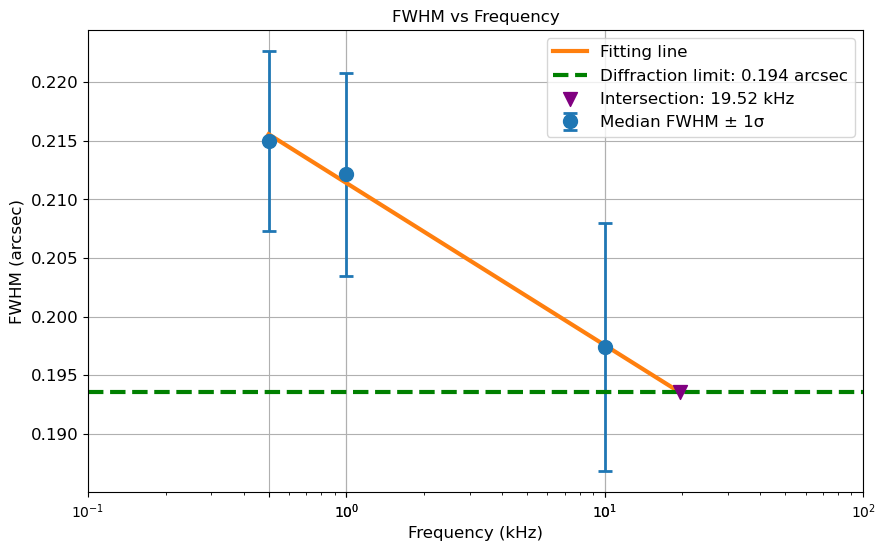

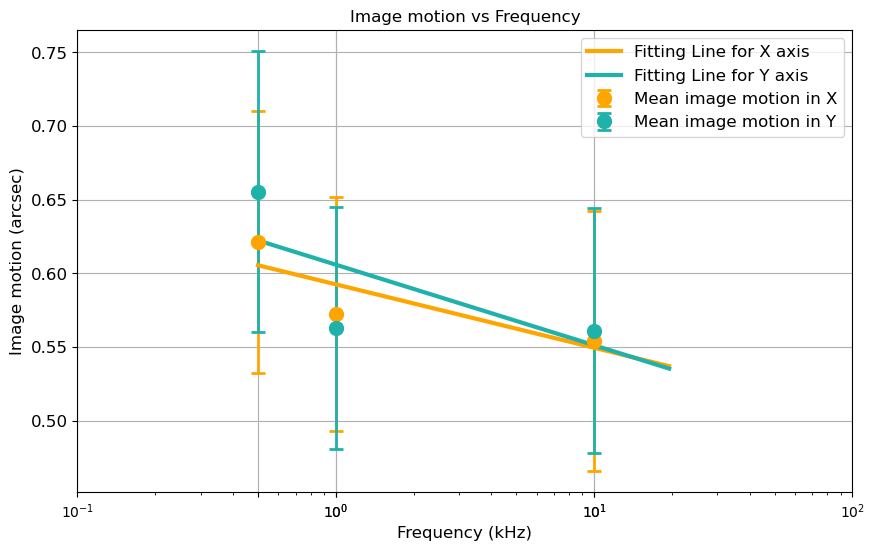

In [ ]:
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

hz_values = [0.5, 1, 10]  # Frequencies in kHz
fwhm_median_values = [np.median(fits.open('results_500Hz_3sigma.fits')['FWHM_MEDIAN'].data),
                      np.median(fits.open('results_1kHz_3sigma_threshold7000.fits')['FWHM_MEDIAN'].data),
                      np.median(fits.open('results_10kHz_threshold1100_fixed.fits')['FWHM_MEDIAN'].data)]

def logarithmic_func(x, a, b):
    return a * np.log(x) + b

params, _ = curve_fit(logarithmic_func, hz_values, fwhm_median_values)
x_fit = np.linspace(min(hz_values), 100, 1000) 
y_fit = logarithmic_func(x_fit, *params)

fwhm_errors = [np.std(fits.open('results_500Hz_3sigma.fits')['FWHM_MEDIAN'].data),
               np.std(fits.open('results_1kHz_3sigma_threshold7000.fits')['FWHM_MEDIAN'].data),
               np.std(fits.open('results_10kHz_threshold1100_fixed.fits')['FWHM_MEDIAN'].data)]

diffraction_limit_index = np.where(y_fit <= diffraction_limit_arcseconds)[0][0]
x_fit = x_fit[:diffraction_limit_index + 1]
y_fit = y_fit[:diffraction_limit_index + 1]

plt.figure(figsize=(10, 6))
plt.errorbar(hz_values, fwhm_median_values, yerr=fwhm_errors, fmt='o', label='Median FWHM ± 1σ', markersize=10, capsize=5, capthick=2, elinewidth=2)
plt.plot(x_fit, y_fit, '-', label='Fitting line', lw=3)
plt.axhline(y=diffraction_limit_arcseconds, color='green', linestyle='--', label=f'Diffraction limit: {diffraction_limit_arcseconds:.3f} arcsec', lw=3)
plt.scatter(x_fit[-1], y_fit[-1], color='purple', marker='v', s=100, zorder=5, label=f'Intersection: {x_fit[-1]:.2f} kHz') 

plt.xlabel('Frequency (kHz)', fontsize='large')
plt.ylabel('FWHM (arcsec)', fontsize='large')
plt.title('FWHM vs Frequency', fontsize='large')
plt.xscale('log')
plt.xlim(1, 10)
plt.xticks(list(filter(lambda x: x > 0, plt.xticks()[0])) + [hz for hz in hz_values if hz > 0])
plt.yticks(fontsize='large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

rms_values_x = [np.mean(fits.open('results_500Hz_3sigma.fits')['RMS'].data[:, 1] * plate_scale),
              np.mean(fits.open('results_1kHz_3sigma_threshold7000.fits')['RMS'].data[:, 1] * plate_scale),
              np.mean(fits.open('results_10kHz_threshold1100_fixed.fits')['RMS'].data[:, 1] * plate_scale)]
rms_values_y = [np.mean(fits.open('results_500Hz_3sigma.fits')['RMS'].data[:, 0] * plate_scale),
              np.mean(fits.open('results_1kHz_3sigma_threshold7000.fits')['RMS'].data[:, 0] * plate_scale),
              np.mean(fits.open('results_10kHz_threshold1100_fixed.fits')['RMS'].data[:, 0] * plate_scale)]

rms_errors_x = [np.std(fits.open('results_500Hz_3sigma.fits')['RMS'].data[:, 1] * plate_scale),
              np.std(fits.open('results_1kHz_3sigma_threshold7000.fits')['RMS'].data[:, 1] * plate_scale),
              np.std(fits.open('results_10kHz_threshold1100_fixed.fits')['RMS'].data[:, 1] * plate_scale)]
rms_errors_y = [np.std(fits.open('results_500Hz_3sigma.fits')['RMS'].data[:, 0] * plate_scale),
              np.std(fits.open('results_1kHz_3sigma_threshold7000.fits')['RMS'].data[:, 0] * plate_scale),
              np.std(fits.open('results_10kHz_threshold1100_fixed.fits')['RMS'].data[:, 0] * plate_scale)]

def logarithmic_func(x, a, b):
    return a * np.log(x) + b

params_rms_x, _ = curve_fit(logarithmic_func, hz_values, rms_values_x)
params_rms_y, _ = curve_fit(logarithmic_func, hz_values, rms_values_y)
y_fit_rms_x = logarithmic_func(x_fit, *params_rms_x)
y_fit_rms_y = logarithmic_func(x_fit, *params_rms_y)
plt.figure(figsize=(10, 6))
plt.errorbar(hz_values, rms_values_x, yerr=rms_errors_x, fmt='o', label='Mean image motion in X ± 1σ', markersize=10, capsize=5, capthick=2, elinewidth=2, color='orange')
plt.errorbar(hz_values, rms_values_y, yerr=rms_errors_y, fmt='o', label='Mean image motion in Y ± 1σ', markersize=10, capsize=5, capthick=2, elinewidth=2, color='lightseagreen')
plt.plot(x_fit, y_fit_rms_x, '-', label='Fitting Line for X axis', lw=3, color='orange')
plt.plot(x_fit, y_fit_rms_y, '-', label='Fitting Line for Y axis', lw=3, color='lightseagreen')
plt.xlabel('Frequency (kHz)', fontsize='large')
plt.ylabel('Image motion (arcsec)', fontsize='large')
plt.title('Image motion vs Frequency', fontsize='large')
plt.xscale('log')
plt.xlim(1, 10)
plt.xticks(list(filter(lambda x: x > 0, plt.xticks()[0])) + [hz for hz in hz_values if hz > 0])
plt.yticks(fontsize='large')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()


# Filtro usato      

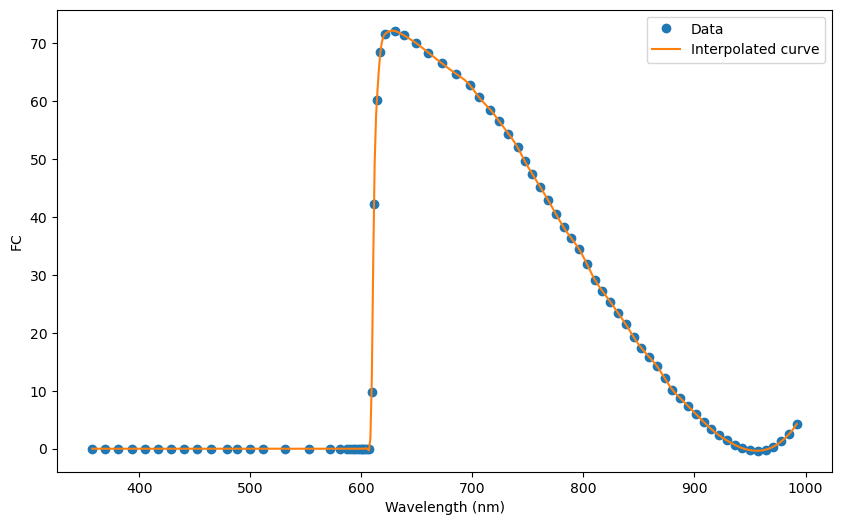

Fitted parameters: [ 68.67183712 700.41361805  75.07100327]
FWHM of the interpolated curve: 176.78 nm
The FWHM is centered at: 700.41 nm


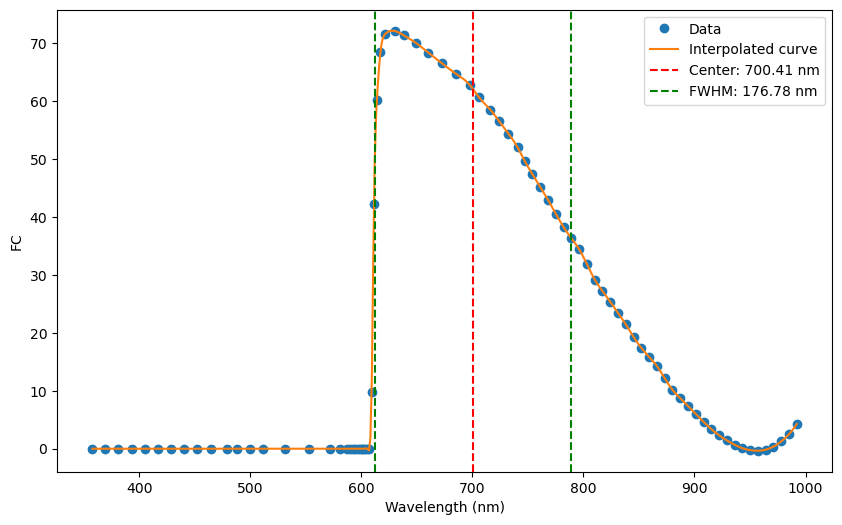

In [19]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


FC = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.792802117,
    42.22064607, 60.24932531, 68.53095612, 71.61271903, 72.11661468, 71.36710551, 69.99424568, 68.36181792,
    66.58858352, 64.72064561, 62.80989168, 60.71647366, 58.55428703, 56.50341945, 54.40668766, 52.03412543,
    49.65316445, 47.39563373, 45.20282357, 42.96088004, 40.53844242, 38.25579086, 36.3267388, 34.43366274,
    31.86702376, 29.19185074, 27.23125553, 25.36669037, 23.45310914, 21.46768915, 19.30472959, 17.39867537,
    15.84982052, 14.27462246, 12.19032906, 10.17676499, 8.730220726, 7.353394501, 5.983831881, 4.656992061,
    3.381963048, 2.313725604, 1.435638797, 0.6792769254, 0.08603742283, -0.248430409, -0.3448092447,
    -0.1607259296, 0.360509121, 1.257907885, 2.516716778, 4.268082589
]

lambd = [
    357.6954772, 369.5095928, 381.3237083, 393.1378239, 404.9517926, 416.765688, 428.5800238, 440.3934786,
    452.2074474, 464.4789576, 478.9585956, 487.650675, 499.4642767, 511.2778784, 530.9947947, 553.1660599,
    572.1726261, 580.5473275, 587.5086922, 590.173934, 592.8373589, 594.4275809, 596.8700261, 598.6699224,
    600.2587312, 601.8463286, 603.0751151, 605.3362975, 607.311131, 609.2507428, 611.3672703, 614.0224853,
    617.2240595, 621.5005594, 630.0751862, 638.2591093, 649.5686048, 660.4276528, 672.1923587, 685.3145307,
    697.5310448, 705.6758412, 716.0837614, 724.2285578, 732.3719933, 740.6829987, 747.1284566, 754.1284566,
    761.1284566, 768.1284566, 775.1284566, 782.1284566, 789.1284566, 796.1284566, 803.1284566, 810.1284566,
    817.1284566, 824.1284566, 831.1284566, 838.1284566, 845.1284566, 852.1284566, 859.1284566, 866.1284566,
    873.1284566, 880.1284566, 887.1284566, 894.1284566, 901.1284566, 908.1284566, 915.1284566, 922.1284566,
    929.1284566, 936.1284566, 943.1284566, 950.1284566, 957.1284566, 964.1284566, 971.1284566, 978.1284566,
    985.1284566, 992.1284566
]

# Interpolate the curve
interp_func = interp1d(lambd, FC, kind='cubic')

# Generate new x values for a smoother curve
lambd_new = np.linspace(min(lambd), max(lambd), num=500)
FC_new = interp_func(lambd_new)

# Plot the interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(lambd, FC, 'o', label='Data')
plt.plot(lambd_new, FC_new, '-', label='Interpolated curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('FC')
plt.legend()
plt.show()

print("Fitted parameters:", params)

# Define a Gaussian function to fit the data
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# Initial guess for the parameters
initial_guess = [max(FC_new), lambd_new[np.argmax(FC_new)], 10]

# Fit the Gaussian model to the data
params, params_covariance = curve_fit(gaussian, lambd_new, FC_new, p0=initial_guess)

# Calculate the FWHM
amp, cen, wid = params
fwhm = 2 * np.sqrt(2 * np.log(2)) * wid

print(f"FWHM of the interpolated curve: {fwhm:.2f} nm")
centered_value = cen
print(f"The FWHM is centered at: {centered_value:.2f} nm")
# Plot the Gaussian fit
plt.figure(figsize=(10, 6))
plt.plot(lambd, FC, 'o', label='Data')
plt.plot(lambd_new, FC_new, '-', label='Interpolated curve')
#plt.plot(lambd_new, gaussian(lambd_new, *params), '--', label='Gaussian fit')
plt.axvline(centered_value, color='r', linestyle='--', label=f'Center: {centered_value:.2f} nm')
plt.axvline(centered_value - fwhm / 2, color='g', linestyle='--', label=f'FWHM: {fwhm:.2f} nm')
plt.axvline(centered_value + fwhm / 2, color='g', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('FC')
plt.legend()
plt.show()